# Analysis of the MC
Here we use Guillermo's code to obtain the required numbers for the MC.

In [2]:
import os
import sys
import warnings
import matplotlib.pyplot as plt
import pickle
import uproot
import numpy as np
import pandas as pd
# import xgboost as xgb
import sklearn

sys.path.insert(0, '../')
# import analysis_utils as au

# avoid pandas warning
warnings.simplefilter(action='ignore', category=FutureWarning)

## A few infos on the libraries

### uproot

uproot is a Python package that provides tools for reading/writing ROOT files using Python and Numpy (does not depend on ROOT) and is primarly intended to stream data into machine learning libraries in Python.

We use uproot for reading and converting ROOT Trees into ***pandas*** **DataFrame**.
For more details: https://github.com/scikit-hep/uproot.

Now we load our data using uproot: signal and background for the training of the models and the unknown data on which we would like to have the model predictions

In [3]:
# IncohMC_std_recon = uproot.open('AnalysisResultsIncoh16s_std.root')['MyTask/fOutputTree']
# IncohMC_std_gener = uproot.open('AnalysisResultsIncoh16s_std.root')['MyTask/fOutputTreeMC']
# IncohMC_std_recon = uproot.open('AnalysisResultsIncoh16s_nolpt.root')['MyTask/fOutputTree']
# IncohMC_std_gener = uproot.open('AnalysisResultsIncoh16s_nolpt.root')['MyTask/fOutputTreeMC']
# IncohMC_std_recon = uproot.open('AnalysisResultsIncoh16s_nopdca.root')['MyTask/fOutputTree']
# IncohMC_std_gener = uproot.open('AnalysisResultsIncoh16s_nopdca.root')['MyTask/fOutputTreeMC']
# IncohMC_std_recon = uproot.open('AnalysisResultsGammaLow16s.root')['MyTask/fOutputTree']
# IncohMC_std_gener = uproot.open('AnalysisResultsGammaLow16s.root')['MyTask/fOutputTreeMC']
# IncohMC_std_recon = uproot.open('AnalysisResultsCoh16s.root')['MyTask/fOutputTree']
# IncohMC_std_gener = uproot.open('AnalysisResultsCoh16s.root')['MyTask/fOutputTreeMC']



# LHC16r
IncohMC_std_recon = uproot.open('AnalysisResultsIncoh16r_std.root')['MyTask/fOutputTree']
IncohMC_std_gener = uproot.open('AnalysisResultsIncoh16r_std.root')['MyTask/fOutputTreeMC']
# IncohMC_std_recon = uproot.open('AnalysisResultsIncoh16r_nolpt.root')['MyTask/fOutputTree']
# IncohMC_std_gener = uproot.open('AnalysisResultsIncoh16r_nolpt.root')['MyTask/fOutputTreeMC']
# IncohMC_std_recon = uproot.open('AnalysisResultsIncoh16r_nopdca.root')['MyTask/fOutputTree']
# IncohMC_std_gener = uproot.open('AnalysisResultsIncoh16r_nopdca.root')['MyTask/fOutputTreeMC']
# IncohMC_std_recon = uproot.open('AnalysisResultsGammaLow16r.root')['MyTask/fOutputTree']
# IncohMC_std_gener = uproot.open('AnalysisResultsGammaLow16r.root')['MyTask/fOutputTreeMC']
# IncohMC_std_recon = uproot.open('AnalysisResultsCoh16r.root')['MyTask/fOutputTree']
# IncohMC_std_gener = uproot.open('AnalysisResultsCoh16r.root')['MyTask/fOutputTreeMC']


In [28]:
IncohMC_std_recon.keys()
# IncohMC_std_gener.keys()
# background_treeMine.keys()
# data_treeMine.keys()

[b'fRunNum',
 b'fL0inputs',
 b'fAnaType',
 b'fGoodPosTrk',
 b'fGoodNegTrk',
 b'fTrkTrkPt',
 b'fTrkTrkPhi',
 b'fTrkTrkY',
 b'fTrkTrkM',
 b'fTrkPt1',
 b'fTrkPt2',
 b'fTrkEta1',
 b'fTrkEta2',
 b'fTrkPhi1',
 b'fTrkPhi2',
 b'fTrkQ1',
 b'fTrkQ2',
 b'fTrkRabs1',
 b'fTrkRabs2']

In [5]:
df_recon = IncohMC_std_recon.pandas.df()
df_gener = IncohMC_std_gener.pandas.df()

In [6]:
len(df_recon.index)

1819814

In [7]:
generatedevents = len(df_gener.index)
generatedevents

10483212

In [8]:
# df_Rapidity_gen = df_gener.query('fMCTrkTrkM > 2.8 & fMCTrkTrkM < 3.3 & fMCTrkTrkY < -2.5 & fMCTrkTrkY > -4.0 ')
df_Rapidity_gen = df_gener.query('fMCTrkTrkY < -2.5 & fMCTrkTrkY > -4.0 ')
generatedevents_Ycut = len(df_Rapidity_gen.index)
generatedevents_Ycut

9321584

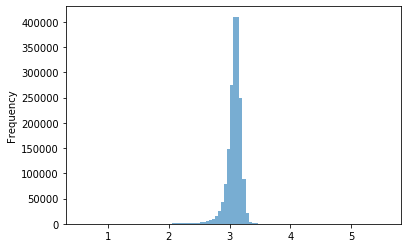

In [9]:
InvMass_recon = df_recon['fTrkTrkM'].plot.hist(bins=100, alpha=0.6)
# minv_bkgMine = df_backgroundMine['fInvariantMassDimuon'].plot.hist(bins=100, alpha=0.6)


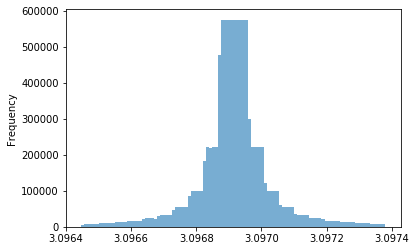

In [10]:
InvMass_gen = df_gener['fMCTrkTrkM'].plot.hist(bins=100, alpha=0.6)


### Pandas 

Pandas is a library that provides data structures and analysis tools for Pyhton. The two primary data structures of pandas are **Series** (1-dimensional) and **DataFrame** (2-dimensional) and we will work with them.

- **Series** are 1-dimensional ndarray with axis labels.
- **DataFrame** are 2-dimensional tabular data structure with labeled axes (rows and columns).

For more details: https://pandas.pydata.org/pandas-docs/stable/





One of the most interesting tool of DataFrame is the *query()* method (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html). With this method we can query the DataFrame getting elements which **satisfy a boolean expression**.

A "trick" to plot more than one distribution is to create a new dataframe with the data to plot in different columns

In [11]:
#dataframe with invariant-mass of background and signal
# df_new = pd.concat([df_background['InvMass'], df_signal['InvMass']], axis=1)
# df_new.head()

In [12]:
# minv_compared = df_new.plot.hist(bins=100, alpha=0.6)

## Data preparation
We need to tell at the model what is signal and what is background.

So we add a 'y' column and label signal and background with **y=1** for signal and **y=0** for background. Then we stack togheter signal and background. This will be the reference for the ML model. 

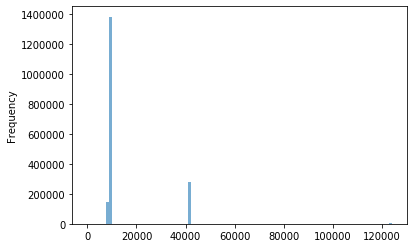

In [13]:
plot_fL0inputs = df_recon['fL0inputs'].plot.hist(bins=100, alpha=0.6)


In [14]:
def return0MSL(x):
    return ((x & (1<<5))>>5)

In [15]:
def return0MUL(x):
    return ((x & (1<<13))>>13)

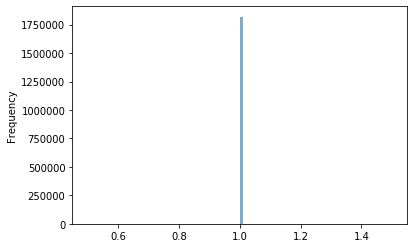

In [16]:
df_recon['f0MSL'] = df_recon.fL0inputs.apply(return0MSL)
plot_0MSL = df_recon['f0MSL'].plot.hist(bins=100, alpha=0.6)


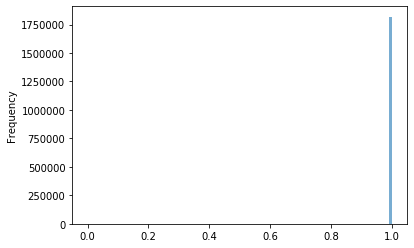

In [17]:
df_recon['f0MUL'] = df_recon.fL0inputs.apply(return0MUL)
plot_0MUL = df_recon['f0MUL'].plot.hist(bins=100, alpha=0.6)


In [18]:
len(df_recon.index)

1819814

1819808

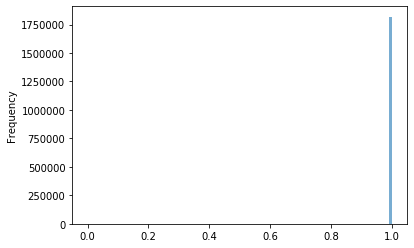

In [19]:
df_InvMassCutPlusRapidity_for0MUL = df_recon.query('fTrkTrkY < -2.5 & fTrkTrkY > -4.0 ')
plot_0MUL_rightrapidity = df_InvMassCutPlusRapidity_for0MUL['f0MUL'].plot.hist(bins=100, alpha=0.6)
len(df_InvMassCutPlusRapidity_for0MUL.index)

1753730

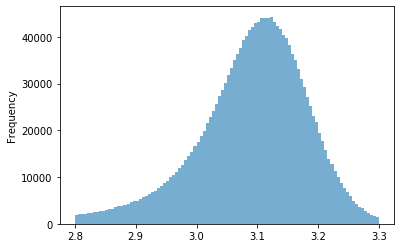

In [20]:
df_InvMassCutPlusRapidity = df_recon.query('fTrkTrkM > 2.8 & fTrkTrkM < 3.3 & fTrkTrkY < -2.5 & fTrkTrkY > -4.0 ')
df_InvMassCutPlusTriggerConditionPlusRapidity = df_InvMassCutPlusRapidity.query('f0MUL > 0.5')
df_InvMassCutPlusTriggerConditionPlusRapidity['fTrkTrkM'].plot.hist(bins=100, alpha=0.6)
reconstructedevents = len(df_InvMassCutPlusTriggerConditionPlusRapidity.index)
reconstructedevents
# len(df_InvMassCutPlusRapidity.index)

1753730

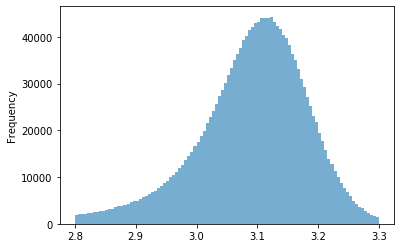

In [21]:
InvMass_recAfterCuts = df_InvMassCutPlusTriggerConditionPlusRapidity['fTrkTrkM'].plot.hist(bins=100, alpha=0.6)
len(df_InvMassCutPlusTriggerConditionPlusRapidity.index)

In [22]:
AxE = reconstructedevents/generatedevents_Ycut
AxE

0.1881364798085819

### Template for Pt distr

In [23]:
bins = np.arange(0,5, 0.10)

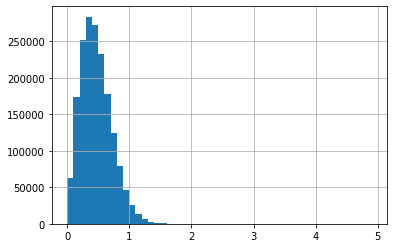

In [24]:
df_InvMassCutPlusTriggerConditionPlusRapidity['fTrkTrkPt'].hist(bins=bins)

In [25]:
PtDistr = df_InvMassCutPlusTriggerConditionPlusRapidity['fTrkTrkPt'].to_numpy()

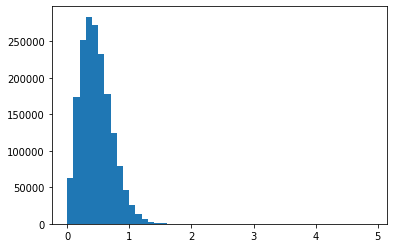

In [26]:
counts, edges, plot = plt.hist(PtDistr, bins=bins)

In [27]:
counts

array([6.22510e+04, 1.73363e+05, 2.51501e+05, 2.83842e+05, 2.72172e+05,
       2.32467e+05, 1.78452e+05, 1.25037e+05, 7.97790e+04, 4.68120e+04,
       2.51750e+04, 1.28210e+04, 5.92900e+03, 2.51000e+03, 9.84000e+02,
       4.29000e+02, 1.28000e+02, 4.70000e+01, 1.50000e+01, 6.00000e+00,
       1.00000e+00, 3.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
       2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00])

Now we can fit the distribution and extract the signal

In [27]:
from scipy.optimize import curve_fit
from scipy import integrate

def fit_invmass(df):
    
    # histogram of the data
    counts, bins = np.histogram(df, bins=40, range=[2.96, 3.05])
    
    # define functions for fitting    
    def gaus_function(x, N, mu, sigma):
        return N * np.exp(-(x-mu)**2/(2*sigma**2))
    
    def pol2_function(x, a, b):
        return (a + x*b)
    
    def fit_function(x, a, b, N, mu, sigma):
        return pol2_function(x, a, b) + gaus_function(x, N, mu, sigma)
    
    # x axis ranges for plots
    x_point = 0.5 * (bins[1:] + bins[:-1])
    r = np.arange(2.96, 3.05, 0.00001)
    r_red = np.arange(2.98, 3.005, 0.0001)
    
    # fit the invariant mass distribution with fit_function() pol2+gauss
    popt, pcov = curve_fit(fit_function, x_point, counts, p0 = [100, -1, 100, 2.99, 0.001])
    
    # plot data
    plt.errorbar(x_point, counts, yerr=np.sqrt(counts), fmt='.', ecolor='k', color='k', elinewidth=1., label='Data')
    
    # plot pol2 and gauss obtained in the fit separately
    plt.plot(r_red, gaus_function(r_red, N=popt[2], mu=popt[3], sigma=popt[4]), label='gaus', color='red')
    plt.plot(r, pol2_function(r, a=popt[0], b=popt[1]), label='pol2', color='green')

    # plot the global fit
    plt.plot(r, fit_function(r, *popt), label='pol2+gauss', color='blue')
    
    # compute significance of the signal
    signal = integrate.quad(gaus_function, 2.98, 3.005, args=(popt[2], popt[3], popt[4]))[0] / 0.00225
    background = integrate.quad(pol2_function, 2.98, 3.005, args=(popt[0], popt[1]))[0] / 0.00225
    print(f'Signal counts: {signal:.0f}')
    print(f'Background counts: {background:.0f}')     
    significance = signal / np.sqrt(signal + background)

    # Add some axis labels
    plt.title(f'significance: {significance:.1f}')
    plt.legend()
    plt.xlabel('$M_{^{3}He+\pi}$ $(\mathrm{GeV/}c^2)$')
    plt.ylabel('counts / 2.25 $\mathrm{MeV/}c^2$')
    plt.show()

In [28]:
fit_invmass(inv_sel_simple)

NameError: name 'inv_sel_simple' is not defined

### Optimized model
We can optimize the hyper-parameters to have a **more complex model**

## Final Excercise

Using the query function of pandas perform the "standard" selections

In [ ]:
df_lin_sel = df_data.query('V0CosPA > 0.995')
inv_mass_lin_sel = df_lin_sel['InvMass']

In [ ]:
fit_invmass(inv_mass_lin_sel)

In [ ]:
import ROOT